## Group Assignment 2: Census Data Exploration

Hi! This is Nathan Keibler. This notebook contains my initial analysis of income data for the City of Los Angeles, which I downloaded from censusreporter.org.

## Loading Libraries

In the cell below, I will upload the relevant libraries for this data exploration.

In [1]:
import pandas as pd

import geopandas as gpd

import contextily as ctx

import matplotlib.pyplot as plt

Output: Based on what we have discussed in lab the last couple weeks, my understanding of these libraries is as follows: 

- pandas helps us with general data wrangling tasks 
- geopandas aids us in reading and visualizing spatial data
- contextily provides us with exciting base maps 
- matplotlib.pyplot gives us an expanded toolset for the plots we generate

## Importing Data

I am retrieving Median Household Income census data (Table B19013) for the City of Los Angeles that was gathered at the block group level. According to the census website, block groups are divisions of census tracts which generally contain 600 - 3,000 people. So, I expect that my map will include a finer grain of information, compared to if we proceeded with data at the census tract level.

I'll retrieve my data using the Census Reporter tool, as this is a much more user-friendly interface to view and extract Census information. The file type I will download is a "GeoJSON," which is an open standard for spatial data that is vector-based (points, lines and polygons that can be combined, unlike shp files). GeoJSON files are also Yoh's favorite.

In [2]:
gdf = gpd.read_file('data (HW Assignment)/acs2019_5yr_B19013_15000US060372318003.geojson')

Output: I have very limited experience working with Census data, so this is definitely my first rodeo taking a close look at it. I'm excited but, admittedly, a bit scared, too... When I read through the webpage for "Income" on Census Reporter (https://censusreporter.org/topics/income/), I learn the following: 

- "Income" has 30 different codes in the Census, which is overwheling to me. All income reported is for "the last 12 months prior to the survey reponse."
- Of these 30 codes, 11 are for median income, which is reported by household and with subsets for "family households" and "nonfamily households." 
- The remaining 19 codes are for aggregate income, which provides the total amount of income for the "summary geography." Not quite sure what that means... Is a census tract a summary geography? Or is that something larger like "LA County?" 
    - Building on this, I'm told that "B19301 - Per Capita Income" is the value for aggregate income divided by the total population estimate for the summary geography and that this is "more or less the 'average' income. 
    - Since averages are affected by outliers, I do not want to use this code. My gut tells me to stick with Median Household Income (B19013). 
- All codes report income as adjusted for inflation for the release year. 
- I also notice a footnote next to some of the codes that tells me that certain datasets are "available in racial iterations." This is interesting and something I'll try to remember to return to later if our research question evolves and we want to explore that variable.

*TLDR: There are many different types of income gathered by the Census. Aggregate vs. Median kind of confuses me, but I decided to go with Median.*

## Inspecting Data

I will now run a couple commands (.shape, .head(), .tail(), .sample(), etc.) to take a closer look at the contents of the dataset.

In [3]:
gdf.shape

(2516, 5)

Output: It appears that there are 2516 block groups in the dataset. It also seems to contain 5 columns. Let's take a closer look using the .head() command.

In [4]:
gdf.head()

geoid                            name  B19013001  \
0  15000US060371011101  Block Group 1, Los Angeles, CA    74125.0   
1  15000US060371011102  Block Group 2, Los Angeles, CA    41625.0   
2  15000US060371011103  Block Group 3, Los Angeles, CA    74886.0   
3  15000US060371011221  Block Group 1, Los Angeles, CA    90611.0   
4  15000US060371011222  Block Group 2, Los Angeles, CA    79868.0   

   B19013001, Error                                           geometry  
0           30142.0  MULTIPOLYGON (((-118.29133 34.26008, -118.2913...  
1           21278.0  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
2           35271.0  MULTIPOLYGON (((-118.30080 34.26327, -118.2979...  
3           11492.0  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
4           44357.0  MULTIPOLYGON (((-118.29075 34.26906, -118.2906...

Output: No surprises here^. It doesn't appear that the first row includes an entire "summary" of income throughout the city of LA (as it did in the lab). So, I don't think I'll need to remove any part of the dataset. Reflection on each column below: 

- geoid: some sort of label for each block group
- name: At first, I thought each Block Group would have a different number so it's odd to see that "Block Group 1" shows up in row 0 and row 3. When I return to the definition of Block Groups provided by the census website, I find the following: "A block group consists of clusters of blocks within the same census tract that have the same first digit of their four-digit census block number.  For example, blocks 3001, 3002, 3003, . . ., 3999 in census tract 1210.02 belong to BG 3 in that census tract." 
    - Still a bit confused here, but it seems that the last digit in the geoid corresponds to the block group name "1, 2, 3"
- B19013001: This is the code for Median Household Income, so I assume that each of the values in this column represent the median household income for each block group.
- B19013001, Error: No clue what's going on here... kinda makes me nervous to see the word "Error" already.. 
- geometry: This is the information needed to generate the outlines of each block group and place them in the correct location on a map.

In [5]:
gdf.sample()

geoid                            name  B19013001  \
1522  15000US060372168003  Block Group 3, Los Angeles, CA    75694.0   

      B19013001, Error                                           geometry  
1522           45295.0  MULTIPOLYGON (((-118.37388 34.05377, -118.3733...

In [6]:
gdf.tail()

geoid                            name  B19013001  \
2511  15000US060379800261  Block Group 1, Los Angeles, CA        NaN   
2512  15000US060379800281  Block Group 1, Los Angeles, CA        NaN   
2513  15000US060379800311  Block Group 1, Los Angeles, CA        NaN   
2514  15000US060379902000  Block Group 0, Los Angeles, CA        NaN   
2515       16000US0644000                 Los Angeles, CA    62142.0   

      B19013001, Error                                           geometry  
2511               NaN  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2512               NaN  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2513               NaN  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2514               NaN  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...  
2515             452.0  MULTIPOLYGON (((-118.66818 34.18987, -118.6681...

Output: Slightly confused why the B19013001 values for Rows 2511-2514 are showing up as "NaN." The values for 2515 seem a bit odd, as well - particularly for "geoid" and "B19013001, Error." I'm wondering if row 2515 is some kind of summary data...? "62142.0" seems similiar to the other values I saw in this same column with the .head() command. I'm not sure if I should delete this or not.. Otherwise, no surprises here.

Row 2515 is still bothering me. I'm going to look at the entire table by overriding the default view settings below. 

In [7]:
pd.set_option('display.max_rows', None)
gdf

geoid                            name  B19013001  \
0     15000US060371011101  Block Group 1, Los Angeles, CA    74125.0   
1     15000US060371011102  Block Group 2, Los Angeles, CA    41625.0   
2     15000US060371011103  Block Group 3, Los Angeles, CA    74886.0   
3     15000US060371011221  Block Group 1, Los Angeles, CA    90611.0   
4     15000US060371011222  Block Group 2, Los Angeles, CA    79868.0   
5     15000US060371012101  Block Group 1, Los Angeles, CA    31758.0   
6     15000US060371012102  Block Group 2, Los Angeles, CA    50179.0   
7     15000US060371012201  Block Group 1, Los Angeles, CA    44798.0   
8     15000US060371012202  Block Group 2, Los Angeles, CA    42778.0   
9     15000US060371013001  Block Group 1, Los Angeles, CA    80000.0   
10    15000US060371013002  Block Group 2, Los Angeles, CA    85417.0   
11    15000US060371013003  Block Group 3, Los Angeles, CA    67344.0   
12    15000US060371013004  Block Group 4, Los Angeles, CA   130694.0   
13    15000US060371014001  Block Group 1, Los Angeles, CA    54067.0   
14    15000US060371014002  Block Group 2, Los Angeles, CA    90278.0   
15    15000US060371014003  Block Group 3, Los Angeles, CA    79125.0   
16    15000US060371021031  Block Group 1, Los Angeles, CA    76833.0   
17    15000US060371021041  Block Group 1, Los Angeles, CA    86563.0   
18    15000US060371021042  Block Group 2, Los Angeles, CA    73167.0   
19    15000US060371021051  Block Group 1, Los Angeles, CA    59432.0   
20    15000US060371021052  Block Group 2, Los Angeles, CA    53500.0   
21    15000US060371021071  Block Group 1, Los Angeles, CA   109800.0   
22    15000US060371021072  Block Group 2, Los Angeles, CA   108194.0   
23    15000US060371031011  Block Group 1, Los Angeles, CA   110000.0   
24    15000US060371031012  Block Group 2, Los Angeles, CA    75536.0   
25    15000US060371031021  Block Group 1, Los Angeles, CA    81250.0   
26    15000US060371031022  Block Group 2, Los Angeles, CA    72463.0   
27    15000US060371031023  Block Group 3, Los Angeles, CA    71094.0   
28    15000US060371031024  Block Group 4, Los Angeles, CA    56786.0   
29    15000US060371031025  Block Group 5, Los Angeles, CA    85486.0   
30    15000US060371032001  Block Group 1, Los Angeles, CA   100417.0   
31    15000US060371032002  Block Group 2, Los Angeles, CA    84554.0   
32    15000US060371032003  Block Group 3, Los Angeles, CA    66351.0   
33    15000US060371033001  Block Group 1, Los Angeles, CA    96765.0   
34    15000US060371033002  Block Group 2, Los Angeles, CA   130938.0   
35    15000US060371034001  Block Group 1, Los Angeles, CA    61349.0   
36    15000US060371034002  Block Group 2, Los Angeles, CA   110447.0   
37    15000US060371034003  Block Group 3, Los Angeles, CA   145949.0   
38    15000US060371034004  Block Group 4, Los Angeles, CA    87542.0   
39    15000US060371034005  Block Group 5, Los Angeles, CA    82857.0   
40    15000US060371041031  Block Group 1, Los Angeles, CA    81181.0   
41    15000US060371041032  Block Group 2, Los Angeles, CA   106136.0   
42    15000US060371041051  Block Group 1, Los Angeles, CA    92368.0   
43    15000US060371041052  Block Group 2, Los Angeles, CA    41250.0   
44    15000US060371041081  Block Group 1, Los Angeles, CA    51921.0   
45    15000US060371041082  Block Group 2, Los Angeles, CA    46375.0   
46    15000US060371041083  Block Group 3, Los Angeles, CA    95714.0   
47    15000US060371041241  Block Group 1, Los Angeles, CA    50605.0   
48    15000US060371041242  Block Group 2, Los Angeles, CA    95278.0   
49    15000US060371041243  Block Group 3, Los Angeles, CA   127782.0   
50    15000US060371042011  Block Group 1, Los Angeles, CA    67863.0   
51    15000US060371042012  Block Group 2, Los Angeles, CA    57132.0   
52    15000US060371042013  Block Group 3, Los Angeles, CA    54716.0   
53    15000US060371042031  Block Group 1, Los Angeles, CA    43594.0   
54    15000US060371042032  Block Group 2, Los Angeles, CA   

Output: Scrolling through all the observations, I feel even weirder about Row 2515 because the "geoid" value is so different from the others (similar to how it was in lab). I suspect this is some sort of summary data about the entire city. I'm going to drop the row with index 2515 (the last row).

In [8]:
gdf = gdf.drop([2515])

In [9]:
gdf.tail()

geoid                            name  B19013001  \
2510  15000US060379800241  Block Group 1, Los Angeles, CA   150250.0   
2511  15000US060379800261  Block Group 1, Los Angeles, CA        NaN   
2512  15000US060379800281  Block Group 1, Los Angeles, CA        NaN   
2513  15000US060379800311  Block Group 1, Los Angeles, CA        NaN   
2514  15000US060379902000  Block Group 0, Los Angeles, CA        NaN   

      B19013001, Error                                           geometry  
2510           13582.0  MULTIPOLYGON (((-118.51849 34.18389, -118.5184...  
2511               NaN  MULTIPOLYGON (((-118.35173 34.28034, -118.3517...  
2512               NaN  MULTIPOLYGON (((-118.45246 33.94315, -118.4464...  
2513               NaN  MULTIPOLYGON (((-118.29105 33.75378, -118.2905...  
2514               NaN  MULTIPOLYGON (((-118.63598 34.03255, -118.6325...

Output: I ran the .tail() command to verify that the row with index 2515 was dropped. I can confirm that it was.

I'm curious to see what the data types are in this set. I'll take a look using the .info() command.

In [10]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2515 entries, 0 to 2514
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geoid             2515 non-null   object  
 1   name              2515 non-null   object  
 2   B19013001         2431 non-null   float64 
 3   B19013001, Error  2415 non-null   float64 
 4   geometry          2515 non-null   geometry
dtypes: float64(2), geometry(1), object(2)
memory usage: 117.9+ KB


Output: I performed a quick check on my data types by using the ".info()" command. With this, I am mostly checking to make sure that there are no "null" items and make sure that there is no missing data. Everything looks okay here!

## Cleaning Data

I will now trim the dataset to remove the column labeled "B19013001, Error." I will then rename the columns and wrap up by doing a couple quick data integrity checks.

In [11]:
columns_to_keep = ['geoid', 'name', 'B19013001', 'geometry']

In [12]:
gdf = gdf[columns_to_keep]

In [13]:
gdf.head()

geoid                            name  B19013001  \
0  15000US060371011101  Block Group 1, Los Angeles, CA    74125.0   
1  15000US060371011102  Block Group 2, Los Angeles, CA    41625.0   
2  15000US060371011103  Block Group 3, Los Angeles, CA    74886.0   
3  15000US060371011221  Block Group 1, Los Angeles, CA    90611.0   
4  15000US060371011222  Block Group 2, Los Angeles, CA    79868.0   

                                            geometry  
0  MULTIPOLYGON (((-118.29133 34.26008, -118.2913...  
1  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
2  MULTIPOLYGON (((-118.30080 34.26327, -118.2979...  
3  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
4  MULTIPOLYGON (((-118.29075 34.26906, -118.2906...

In [14]:
list(gdf)

['geoid', 'name', 'B19013001', 'geometry']

In [15]:
gdf.columns = ['geoid', 'Block Group Name', 'Median Household Income', 'geometry']

In [16]:
gdf.head()

geoid                Block Group Name  \
0  15000US060371011101  Block Group 1, Los Angeles, CA   
1  15000US060371011102  Block Group 2, Los Angeles, CA   
2  15000US060371011103  Block Group 3, Los Angeles, CA   
3  15000US060371011221  Block Group 1, Los Angeles, CA   
4  15000US060371011222  Block Group 2, Los Angeles, CA   

   Median Household Income                                           geometry  
0                  74125.0  MULTIPOLYGON (((-118.29133 34.26008, -118.2913...  
1                  41625.0  MULTIPOLYGON (((-118.30229 34.25870, -118.3009...  
2                  74886.0  MULTIPOLYGON (((-118.30080 34.26327, -118.2979...  
3                  90611.0  MULTIPOLYGON (((-118.30334 34.27371, -118.3033...  
4                  79868.0  MULTIPOLYGON (((-118.29075 34.26906, -118.2906...

Output: I feel good about the changes! I removed the "Error" column that was freaking me out and made the column labels more relevant.

## Preliminary Plot

I will now run a quick .plot() test to see how the dataset I loaded plots.

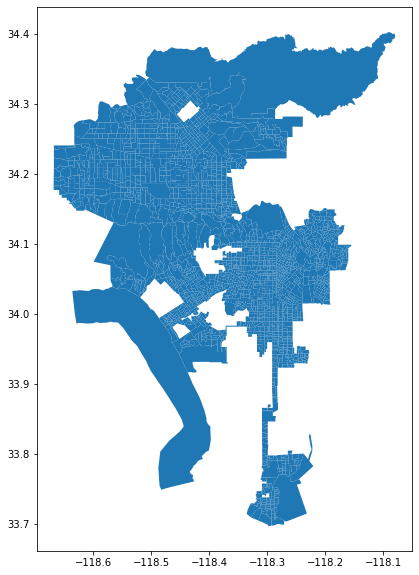

In [17]:
gdf.plot(figsize=(10,10))

Output: This seems pretty straightforward. Two surprises, though: 

- There is a strange geometry that follows the shoreline along the city's westernmost portion and even extends down as far as Rancho Palos Verdes. It almost seems as if the geometry was generated by offsetting the shoreline vector. Not sure why this is showing up.. 
- It seems that a portion of the Angeles National Forest has also been generated in the northeastern-most portion of this plot. Also unclear why that is happening.

## Double checking data integrity

Just to be safe, I want to do a couple "spot checks" on my dataset, similar to how they were conducted in lab. I'll complete those below. 

In [18]:
random_block = gdf.sample()
random_block

geoid                Block Group Name  \
1239  15000US060372037201  Block Group 1, Los Angeles, CA   

      Median Household Income  \
1239                  40972.0   

                                               geometry  
1239  MULTIPOLYGON (((-118.20679 34.04837, -118.2066...

Now I will use the .iloc command to locate a specific cell based on the position of the record row and column name. In this instance, I will try to get the value in the "Median Household Income" column for the 1239th record.

In [19]:
random_block.iloc[0]['Median Household Income']

40972.0

Output: Great! The value it generated matches what is listed in the "Median Household Income," 40972.0. 

## Simple stats and plots

I am now going to run a few commands to generate some simple statistical measures for my dataset (mean, median, etc).

In [20]:
gdf['Median Household Income'].mean()

72894.33730974907

In [21]:
gdf['Median Household Income'].median()

62212.0

In [22]:
gdf['Median Household Income'].describe()

count      2431.000000
mean      72894.337310
std       41354.002518
min        4645.000000
25%       43974.000000
50%       62212.000000
75%       90832.500000
max      250001.000000
Name: Median Household Income, dtype: float64

Output: Here, I'm generating statistical information for the "Median Household Income" column. I find that the mean is 72894.33 and that the median (lol kind of weird... the median of all the medians in the city) is 62212.0. When I run the .describe() command, I find even more information: standard deviation of 41354.00, a minimum value of 4645.00 and a maximum value of 250001.00.

Now I will try to generate a histogram with 50 bins (similar to how we did it in lab).

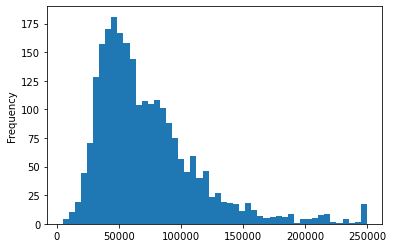

In [23]:
gdf['Median Household Income'].plot.hist(bins=50)

Output: Veryyy interesting.. Still new to this whole "stats" thing, but this does not appear to be a normal distribution. This looks like a positively skewed distribution, due to there being some extremely high values pulling the distribution to the right. Considering we are looking at income, this is to be expected in a city like Los Angeles that has a significant wealth gap. Surprising that there appears to be roughly 25 instances of block groups with a median household income of around 250,000.

## Sorting

Now I will attempt to sort the data. I'm curious to see which block groups have the highest median household incomes and which have the lowest. I'll do the lowest first.

In [24]:
gdf_sorted = gdf.sort_values(by='Median Household Income', ascending = True)
gdf_sorted[['geoid', 'Median Household Income']].head(10)

geoid  Median Household Income
1291  15000US060372063001                   4645.0
1293  15000US060372063003                   8888.0
1677  15000US060372247003                   9432.0
1289  15000US060372062001                   9471.0
1658  15000US060372227001                   9632.0
1675  15000US060372247001                   9844.0
1292  15000US060372063002                  10494.0
1638  15000US060372218202                  11045.0
1639  15000US060372219001                  11104.0
1298  15000US060372073011                  11413.0

Output: My understanding is that this ^ shows the ten block groups with the lowest median household income values.

Now I will attempt to see which block groups have the highest median household incomes.

In [25]:
gdf_sorted = gdf.sort_values(by='Median Household Income', ascending = False)
gdf_sorted[['geoid', 'Median Household Income']].head(10)

geoid  Median Household Income
2087  15000US060372627062                 250001.0
2073  15000US060372623032                 250001.0
816   15000US060371417003                 250001.0
814   15000US060371417001                 250001.0
1369  15000US060372110004                 250001.0
2117  15000US060372654101                 250001.0
2119  15000US060372654201                 250001.0
1366  15000US060372110001                 250001.0
2082  15000US060372626042                 250001.0
724   15000US060371352036                 250001.0

Output: This ^ shows the ten block groups with the highest median household incomes in the city. It seems a bit odd to me that they all have the exact same value for "Median Household Income"...

## Maps

Now I will attempt to plot the block groups in a variety of ways by creating choropleth maps. I'll start by plotting the 10 block groups with the highest Median Household Income.

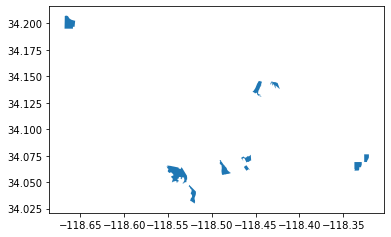

In [26]:
gdf_sorted.head(10).plot()

Output: This is interesting, but I really don't know where these blocks are in relation to the rest of LA.

I will try to make this prettier now.

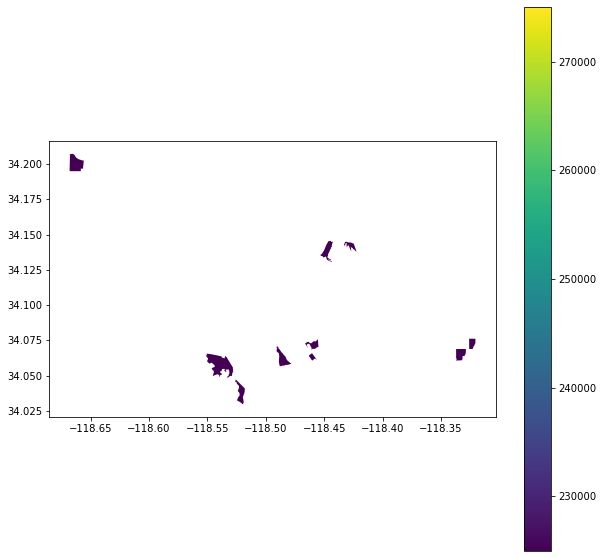

In [27]:
gdf_sorted.head(10).plot(figsize=(10,10),column='Median Household Income',legend=True)

I'll run this again but include the 100 block groups with the highest Median Household Incomes, rather than the top 10.

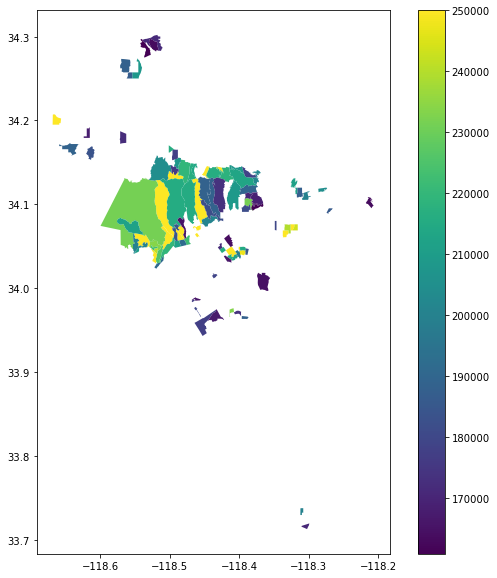

In [28]:
gdf_sorted.head(100).plot(figsize=(10,10),column='Median Household Income',legend=True)

Output: This is interesting... The extents of the city boundaries are starting to take shape..

I'm curious to see if there's a way for me to show the block groups that have above a certain median household income. Let's try >$50,000. I will attempt to try that below.

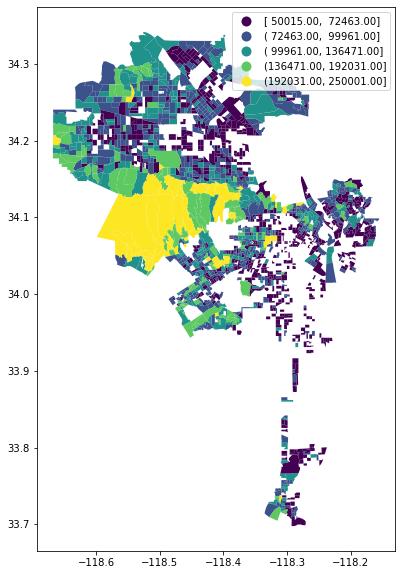

In [29]:
gdfabove50 = gdf[gdf['Median Household Income']>50000]
gdfabove50.plot(figsize=(10,10),
                 column='Median Household Income',
                 legend=True, 
                 scheme='NaturalBreaks')

Output: Wow it worked! Now I want to try the same thing but below a certain median household income. Let's try <$50,000 this time. I will also experiment with the "scheme" options presented in lab (natural breaks, equal interval, quantiles)

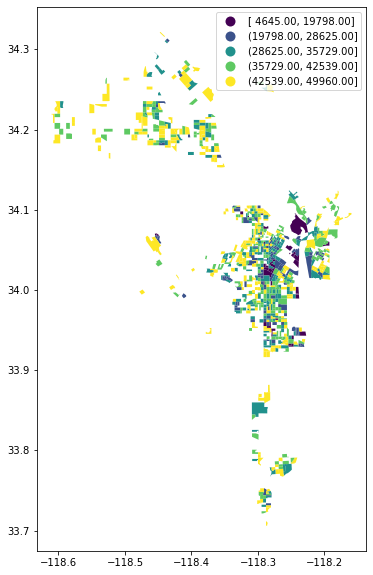

In [30]:
gdfbelow50 = gdf[gdf['Median Household Income']<50000]
gdfbelow50.plot(figsize=(10,10),
                 column='Median Household Income',
                 legend=True, 
                 scheme='NaturalBreaks')

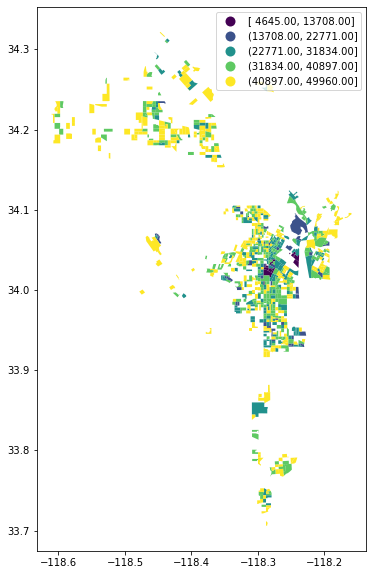

In [31]:
gdfbelow50 = gdf[gdf['Median Household Income']<50000]
gdfbelow50.plot(figsize=(10,10),
                 column='Median Household Income',
                 legend=True, 
                 scheme='EqualInterval')

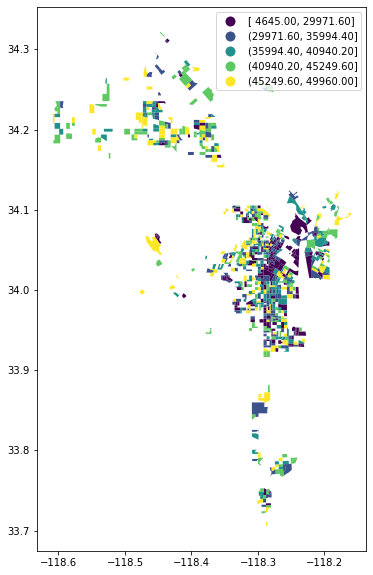

In [32]:
gdfbelow50 = gdf[gdf['Median Household Income']<50000]
gdfbelow50.plot(figsize=(10,10),
                 column='Median Household Income',
                 legend=True, 
                 scheme='Quantiles')

Output: The block groups with the lowest Median Household Incomes appear to be concentrated in South LA. There are also some block groups further south near Long Beach, as well as throughout the San Fernando Valley.

Ok now I want to create two plots that sit side by side. The first will show the block groups with Median Household Income values below 50000. The second will show block groups with Median Household Income values above 150000. First I will need to create a new geodataframe called "gdfabove150". After this, I will generate the two plots.

In [33]:
gdfabove150 = gdf[gdf['Median Household Income']>150000]

Text(0.5, 1.0, 'Median Household Income Above $150,000')

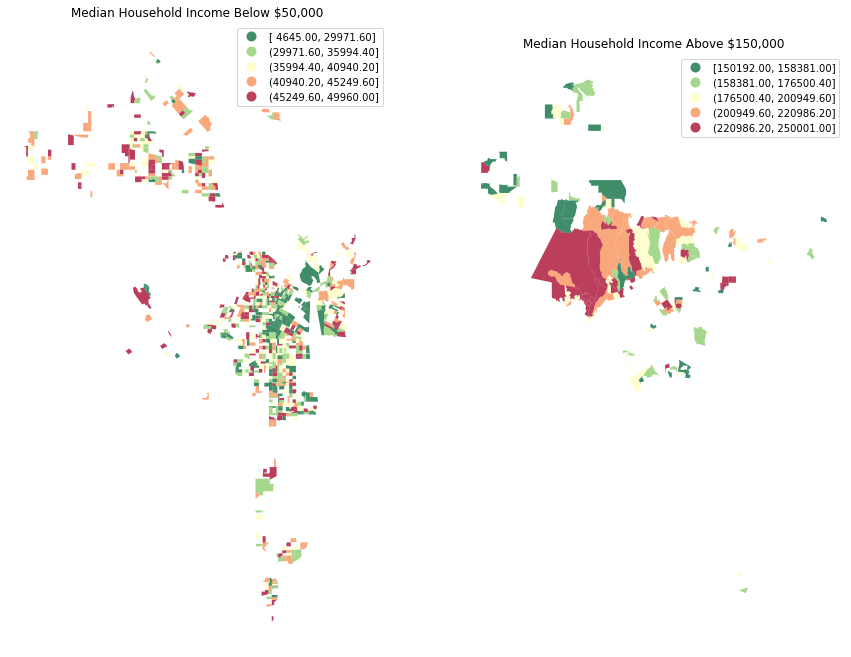

In [34]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 15))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
gdfbelow50.plot(column='Median Household Income', 
            cmap='RdYlGn_r', 
            scheme='quantiles',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax1, # this assigns the map to the subplot,
            legend=True
           )

ax1.axis("off")
ax1.set_title("Median Household Income Below $50,000")

# spatial lag map on the right
gdfabove150.plot(column='Median Household Income', 
            cmap='RdYlGn_r', 
            scheme='quantiles',
            k=5, 
            edgecolor='white', 
            linewidth=0., 
            alpha=0.75, 
            ax=ax2, # this assigns the map to the subplot
            legend=True
           )

ax2.axis("off")
ax2.set_title("Median Household Income Above $150,000")

Output: It worked. Although, I do wonder if there is a way to generate a simple boundary line of the entire city on both of these maps. That would be helpful to see. I suppose we could do this using the basemaps provided by the contextily library. I'll try that out in a bit.

## Filtering and subsetting data

Similar to how I created the > 150000, > 50000, and < 50000 filters in the plot experiments above, I'd like to explore how to do this in "printed" form and combine the results with strings.

In [35]:
print('There are '+str(len(gdfbelow50))+' census block groups with Median Household Incomes that are less than $50,000.')

There are 819 census block groups with Median Household Incomes that are less than $50,000.


Output: It worked! Now I know that the plots I generated in previously cells for block groups with Median Household Incomes less than 50000 contain 819 geometries.

## Adding a basemap

Now I will attempt to add a basemap to the census data I loaded by using the contextily library. First I'll reproject the geodataframe to Web Mercator. This is very important because our data is initially provided in decimal degrees, which will not register with our basemap. We have to convert the data to Web Mercator.

In [36]:
gdf_web_mercator = gdf.to_crs(epsg=3857)

I'll do a quick data check to be sure that the decimal degrees were converted.

In [37]:
gdf_web_mercator.head()

geoid                Block Group Name  \
0  15000US060371011101  Block Group 1, Los Angeles, CA   
1  15000US060371011102  Block Group 2, Los Angeles, CA   
2  15000US060371011103  Block Group 3, Los Angeles, CA   
3  15000US060371011221  Block Group 1, Los Angeles, CA   
4  15000US060371011222  Block Group 2, Los Angeles, CA   

   Median Household Income                                           geometry  
0                  74125.0  MULTIPOLYGON (((-13168130.287 4063777.973, -13...  
1                  41625.0  MULTIPOLYGON (((-13169350.794 4063591.834, -13...  
2                  74886.0  MULTIPOLYGON (((-13169185.150 4064208.314, -13...  
3                  90611.0  MULTIPOLYGON (((-13169467.902 4065613.937, -13...  
4                  79868.0  MULTIPOLYGON (((-13168066.056 4064987.278, -13...

Output: Great! I know they were converted because the values listed in the geometry column are much larger than they were in their original "decimal degree" format.

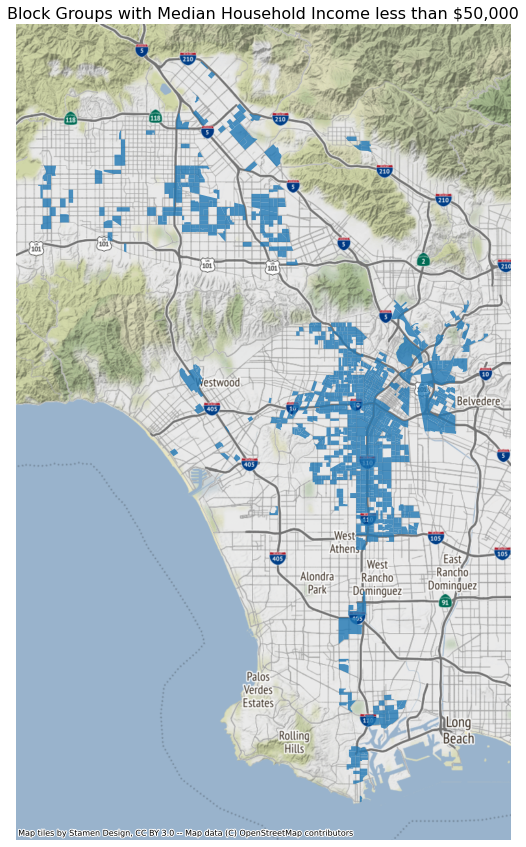

In [38]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# add the layer with ax=ax in the argument 
gdf_web_mercator[gdf_web_mercator['Median Household Income'] < 50000].plot(ax=ax, alpha=0.8)

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Block Groups with Median Household Income less than $50,000',fontsize=16)

# add a basemap
ctx.add_basemap(ax)

Great, it worked! Now I'll do the same but for block groups with Median Household Incomes greater than 150000.

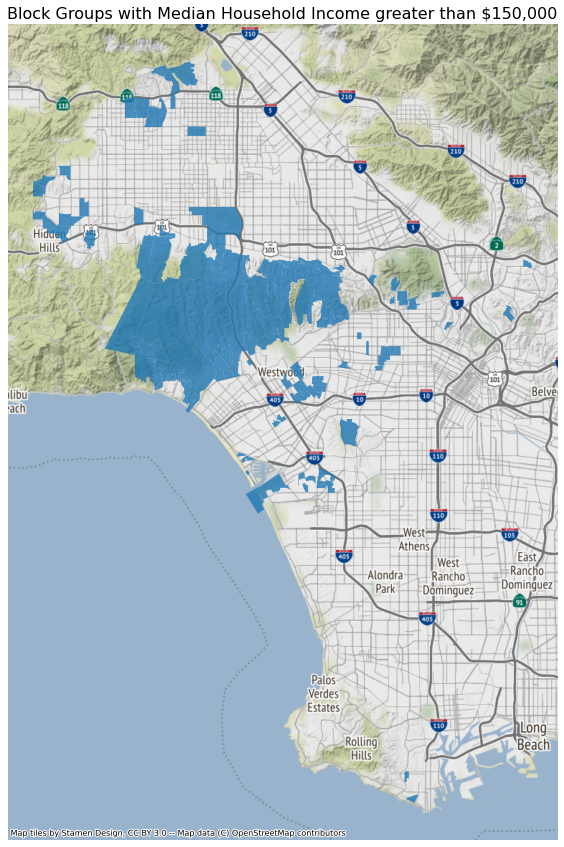

In [39]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# add the layer with ax=ax in the argument 
gdf_web_mercator[gdf_web_mercator['Median Household Income'] > 150000].plot(ax=ax, alpha=0.8)

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Block Groups with Median Household Income greater than $150,000',fontsize=16)

# add a basemap
ctx.add_basemap(ax)

Now I want it to be pretty.

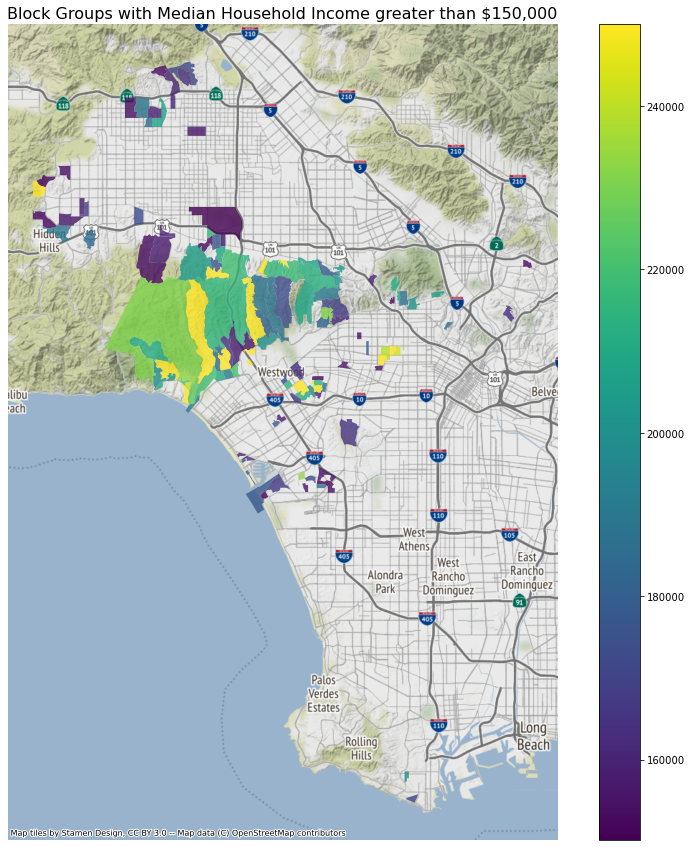

In [40]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# add the layer with ax=ax in the argument 
gdf_web_mercator[gdf_web_mercator['Median Household Income'] > 150000].plot(ax=ax, alpha=0.8, column='Median Household Income', legend = True)

# turn the axis off
ax.axis('off')

# set a title
ax.set_title('Block Groups with Median Household Income greater than $150,000',fontsize=16)

# add a basemap
ctx.add_basemap(ax)

Ok, last thing - I want to try to create the same side by side maps I generated earlier, but I would like for both of them to have base maps. I'd also like for each one to have a different color scheme to make the information I am trying to show more legible. If they both had the same color scheme, it would be confusing to see the same colors represented for vastly different values (ex. yellow simultaneously represents 40000 and 150000)

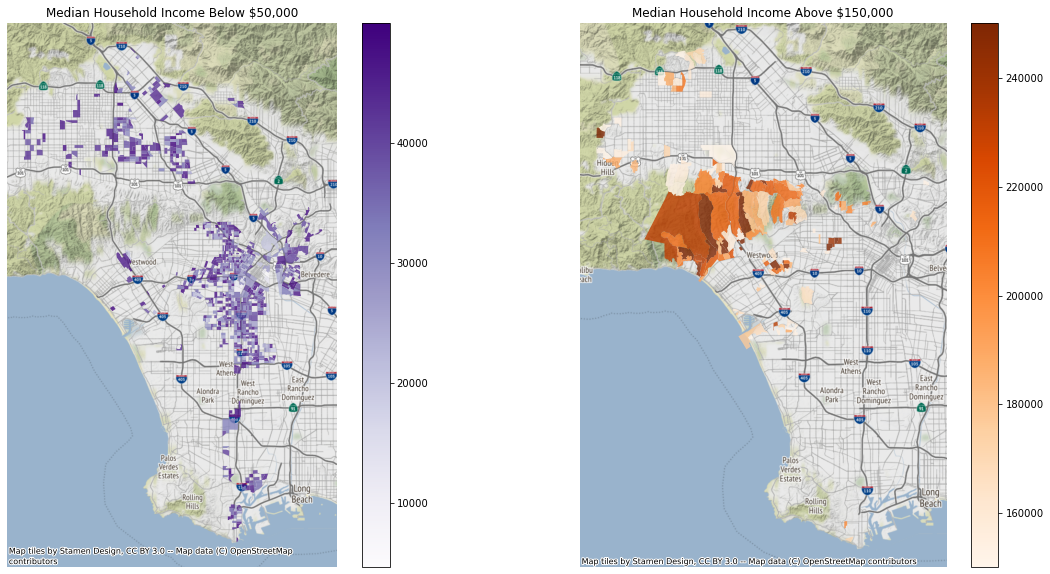

In [41]:
# create the 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# name each subplot
ax1, ax2 = axs

# regular count map on the left
gdf_web_mercator[gdf_web_mercator['Median Household Income'] < 50000].plot(ax=ax1, alpha=0.8, column='Median Household Income', cmap='Purples', legend = True)

# turn the axis off
# set a title
ax1.axis("off")
ax1.set_title("Median Household Income Below $50,000")

# add a basemap
ctx.add_basemap(ax1)

# spatial lag map on the right
gdf_web_mercator[gdf_web_mercator['Median Household Income'] > 150000].plot(ax=ax2, alpha=0.8, column='Median Household Income', cmap='Oranges', legend = True)

# turn the axis off
# set a title
ax2.axis("off")
ax2.set_title("Median Household Income Above $150,000")

# add a basemap
ctx.add_basemap(ax2)

Output: Nice! I'm pretty happy with that. This was really fun!